# Generative Adversarial Networks

Rafiq Premji - CSCA 5642

## Problem Description
The challenge for this project is to generate images in the artistic style of Claude Monet and the goal is to train a generative adversarial network (GAN) to produce fake images that resemble Monet's distinctive style. Success is measured by an evaluation metric called MiFID, a variation of the Frechet Inception Distance (FID) that takes training image memorization into account.

Generative Deep Learning models are a type of neural network that learn how to produce new data instances that resemble an original dataset. Instead of classifying or analyzing existing data, they synthesize new examples that share similar statistical properties with the original data. A Generative Adversarial Network consists of two competing neural networks trained simultaneously:
- **Generator:** Attempts to generate synthetic data indistinguishable from real data.
- **Discriminator:** Attempts to distinguish real from synthetic data.

The two networks train in a cooperative setting where the discriminator improves its ability to spot fake samples while the generator gets better at tricking the discriminator. This leads to the generator producing more realistic looking results.

In [1]:
# import everything

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import torchvision.transforms as transforms
import itertools
import time
from hashlib import md5
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from glob import glob
from IPython.display import display, HTML


torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
sns.set_theme(style='whitegrid')

Using device: cuda


In [2]:
base_path = 'week5-data/'

## Exploratory Data Analysis (EDA)

In [3]:
# # load/unzip data from gdrive (only needed on Google Colab)
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip -o "/content/drive/MyDrive/Colab/week5-data.zip" -d "/content/"
#
# base_path = '/content/week5-data/'

In [4]:
# load monets/photos
monet_path = base_path+'monet_jpg/'
photo_path = base_path+'photo_jpg/'

monet_images = glob(os.path.join(monet_path, '*.jpg'))
photo_images = glob(os.path.join(photo_path, '*.jpg'))

print(f'Monet images: {len(monet_images)}')
print(f'Photo images: {len(photo_images)}')

Monet images: 300
Photo images: 7038


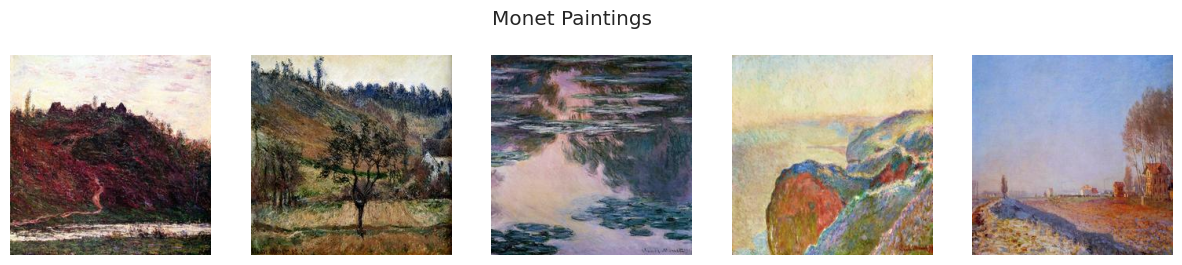

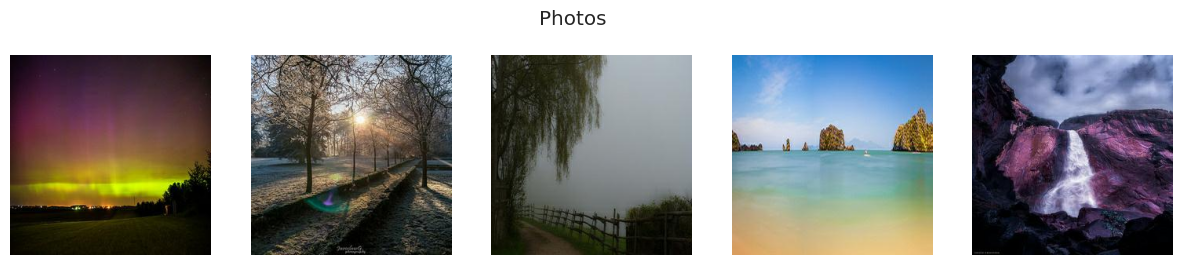

In [5]:
# look at some sample images

def show_some_images(image_paths, title, n_samples=5):
    plt.figure(figsize=(15,3))
    sample_images = random.sample(image_paths, n_samples)
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_some_images(monet_images, 'Monet Paintings')
show_some_images(photo_images, 'Photos')

In [6]:
# check image size/channels

sample_img = Image.open(monet_images[0])
print('Image dimensions (width x height):', sample_img.size)
print('Image channels:', sample_img.mode)

Image dimensions (width x height): (256, 256)
Image channels: RGB


### Data Description
The dataset provided for this competition is structured into four directories:
- **monet_jpg**: 300 JPG images of Monet paintings, sized 256x256.
- **monet_tfrec**: The same images in TFRecord format (will not be using)
- **photo_jpg**: 7028 photographs, sized 256x256.
- **photo_tfrec**: The same images in TFRecord format (will not be using)

The dimensions are:
- **Total Monet paintings**: 300 images
- **Total photos**: 7028 images
- **Image format**: JPG and TFRecord
- **Image dimensions**: 256x256 pixels
- **Color Channels**: 3 (RGB)

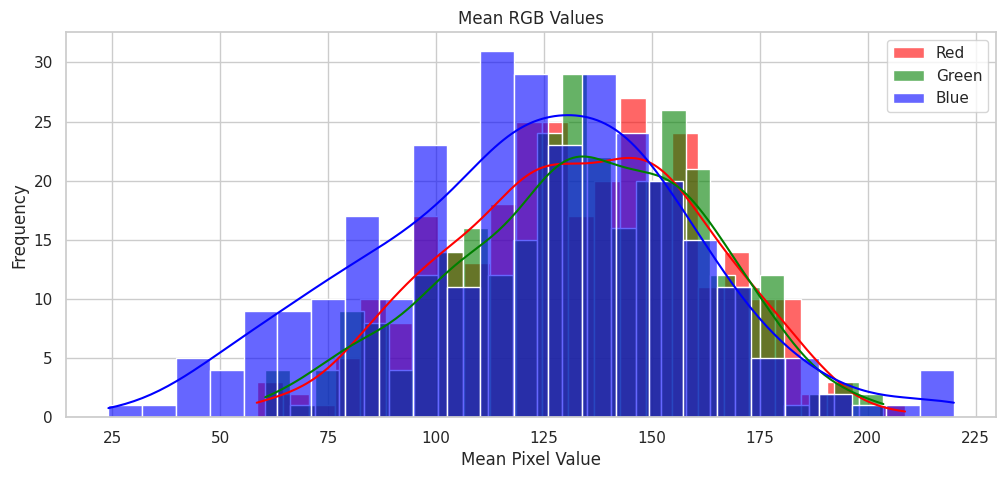

In [7]:
# plot a histogram of the average RGB values

def get_mean_rgb(image_path):
    img = np.array(Image.open(image_path))
    mean_rgb = img.mean(axis=(0,1))
    return mean_rgb

monet_rgb = [get_mean_rgb(img) for img in monet_images]
monet_rgb = np.vstack(monet_rgb)

plt.figure(figsize=(12, 5))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors):
    sns.histplot(monet_rgb[:, i], color=color.lower(), bins=25, kde=True, label=color, alpha=0.6)
plt.title('Mean RGB Values')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

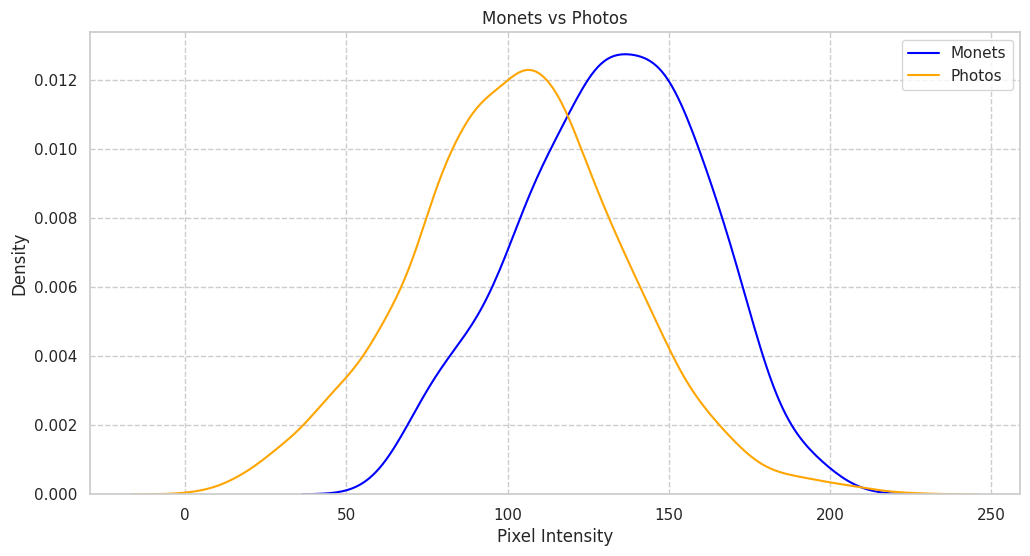

In [8]:
# I also thought it would be interesting to look at the pixel density of monets vs photos, even though I didn't end up using the photos. the monets have a significantly higher average pixel intensity.

def get_intensity_distribution(image_paths):
    intensities = []
    for img_path in image_paths:
        img = np.array(Image.open(img_path).convert('L')) # convert to grayscale
        intensity_mean = img.mean()
        intensities.append(intensity_mean)
    return intensities

monet_intensities = get_intensity_distribution(monet_images)
photo_intensities = get_intensity_distribution(photo_images)

plt.figure(figsize=(12,6))
sns.kdeplot(monet_intensities, color='blue', label='Monets')
sns.kdeplot(photo_intensities, color='orange', label='Photos')
plt.title('Monets vs Photos')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

### Data Cleaning

In [9]:
# check all images have correct size and RGB mode (all looks good)
incorrect_dim_monet = [img for img in monet_images if Image.open(img).size != (256, 256)]
incorrect_mode_monet = [img for img in monet_images if Image.open(img).mode != 'RGB']

print(f"Monets with incorrect dimensions: {len(incorrect_dim_monet)}")
print(f"Monets with non-RGB channels: {len(incorrect_mode_monet)}")

Monets with incorrect dimensions: 0
Monets with non-RGB channels: 0


In [10]:
# look for duplicates (none found)

def get_image_hash(image_path):
    img = np.array(Image.open(image_path))
    return md5(img).hexdigest()

monet_hashes = [get_image_hash(img) for img in monet_images]
monet_duplicate_counts = len(monet_hashes) - len(set(monet_hashes))
print("Duplicate Monets:", monet_duplicate_counts)

Duplicate Monets: 0


## Model Architecture

For this task I originally chose CycleGAN as it seemed to have good a success record on this task and I was interested in doing "style transfer," but after following several example notebooks and tutorials I found the architecture to be a bit overwhelming, so I ended up deleting that code and am now going to try a DCGAN (Deep Convolutional Generative Adverserial Network). I chose DCGAN as it seems simpler to implement than CycleGAN because the architecture is more straightforward.

The two competing models of a DCGAN are the:
- **Generator:** Receives a random input vector and applies multiple convolution/transpose ("deconvolution") layers to gradually upsample the noise into a realistic-looking image. Each deconvolution layer is typically followed by a batch normalization and ReLU activation.
- **Discriminator:** Takes an input image and applies convolutional layers to downsample and extract features from it, with the goal of classifying the image as real or fake. Each convolutional layer uses LeakyReLU activations and batch normalization and the final output is a sigmoid.

Also after using Tensorflow for my last few projects I decided to use Pytorch for this one because I wanted to try a different framework and read that Pytorch is easier to get running in Colab and other cloud notebooks (which I may need to do depending on how this runs on my 3080 GPU).

The DCGAN will be generating brand new images from noise so I will not be using the photographs dataset for this task and will only need the 300 Monet pictures as training data. I am also scaling inputs/outputs down from 256x256 to 64x64 after my initial attempts at a 256x256 model were unsuccessful, and read some advice to get a model stable with smaller images before going up in size.

### Loss Functions

GANs utilize two competing loss functions:
- **Discriminator Loss:** The discriminator network optimizes toward correctly classifying images a real, using a standard BCE (Binary Cross Entropy) loss.
- **Generator Loss:** The generator network optimizes toward fooling the discriminator into classifying fake images as real, using a modified BCE loss function.

An adversarial training approach encourages the generator to continuously improve its outputs until the discriminator can no longer distinguish real paintings from generated ones. The two most common loss functions appear to be BCE (Binary Cross Entropy) and MSE (Mean Squared Error) so I have included them in my hyperparameter selection process below.

In [11]:
# generate a 64x64 monet image

class Generator64(nn.Module):
    def __init__(self, latent_dim, feature_maps_gen):
        super(Generator64, self).__init__()
        self.gen = nn.Sequential(
            # latent_dim x 1 x 1 --> fmap*8 x 4 x 4
            nn.ConvTranspose2d(latent_dim, feature_maps_gen*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps_gen*8),
            # nn.InstanceNorm2d(feature_maps_gen*8),
            nn.ReLU(True),

            # fmap*8 x 4 x 4 --> fmap*4 x 8 x 8
            nn.ConvTranspose2d(feature_maps_gen*8, feature_maps_gen*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_gen*4),
            nn.ReLU(True),

            # fmap*4 x 8 x 8 --> fmap*2 x 16 x 16
            nn.ConvTranspose2d(feature_maps_gen*4, feature_maps_gen*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_gen*2),
            nn.ReLU(True),

            # fmap*2 x 16 x 16 --> fmap x 32 x 32
            nn.ConvTranspose2d(feature_maps_gen*2, feature_maps_gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_gen),
            nn.ReLU(True),

            # fmap x 32 x 32 --> 3 x 64 x 64
            nn.ConvTranspose2d(feature_maps_gen, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.gen(z)

In [12]:
# discriminate between a real & fake 64x64 monet

class Discriminator64(nn.Module):
    def __init__(self, feature_maps_disc):
        super(Discriminator64, self).__init__()
        self.disc = nn.Sequential(
            # 3 x 64 x 64 -> feat_maps_disc x 32 x 32
            nn.Conv2d(3, feature_maps_disc, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # feat_maps_disc x 32 x 32 -> feat_maps_disc*2 x 16 x 16
            nn.Conv2d(feature_maps_disc, feature_maps_disc * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_disc * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # feat_maps_disc*2 x 16 x 16 -> feat_maps_disc*4 x 8 x 8
            nn.Conv2d(feature_maps_disc*2, feature_maps_disc *4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps_disc * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # feat_maps_disc*4 x 8 x 8 -> 1 x 1 x 1
            nn.Conv2d(feature_maps_disc*4, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1).squeeze(1)

### Hyperparameter Tuning

The parameters I chose to tune are:
- Learning Rate
- Beta1
- Latent Dimensions
- Feature Map
- Loss Function (BCE or MSE)


In [13]:
# augment/normalize data for training
transform = transforms.Compose([
    # originally I was trying additional data augmentation through rotation/jitter but it led to worse results
    # transforms.RandomRotation(degrees=10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# wrap the dataset in a class that can be used by the pytorch DataLoader
class MonetDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.image_paths = glob(os.path.join(images_path, '*.jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

monet_dataset = MonetDataset(monet_path, transform=transform)
monet_loader = DataLoader(monet_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [14]:
# stable weights initialization led to better results

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [15]:
# computing a full MiFID seems cumbersome so I'll approximate it by calculating FID instead

from torch_fidelity import calculate_metrics
import tempfile
import os
from torchvision.utils import save_image

def compute_fid(real_loader, gen_model, latent_dim, device, num_images=100):
    gen_model.eval()
    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as fake_dir:
        image_counter = 0
        for real_images in real_loader:
            for real_img in real_images:
                save_image((real_img + 1) / 2, os.path.join(real_dir, f'real_{image_counter}.png'))
                image_counter += 1
                if image_counter >= num_images:
                    break
            if image_counter >= num_images:
                break

        for i in range(num_images):
            noise = torch.randn(1, latent_dim, 1, 1, device=device)
            fake_img = gen_model(noise)
            save_image((fake_img.squeeze(0) + 1) / 2, os.path.join(fake_dir, f'fake_{i}.png'))

        metrics = calculate_metrics(input1=fake_dir, input2=real_dir, cuda=device.type=='cuda', isc=False, fid=True, kid=False, verbose=False)

    gen_model.train()
    return metrics['frechet_inception_distance']

In [16]:
# helper functions to save/display images for a specific model

def save_sample_images(gen, latent_dim, device, num_samples=4, save_to_disk=False):
    gen.eval()
    fixed_noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        fake_images = gen(fixed_noise)

    samples = [fake_images[i] for i in range(num_samples)]
    if save_to_disk:
        save_dir = "generated_samples"
        os.makedirs(save_dir, exist_ok=True)
        for idx, img in enumerate(samples):
            save_image((img + 1) / 2, os.path.join(save_dir, f'sample_{idx}.png'))

    gen.train()
    return samples

def display_saved_images(sample_images):
    grid = torchvision.utils.make_grid(sample_images, normalize=True, padding=2)
    plt.figure(figsize=(10,5))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [32]:
# train/evaluate DCGAN with a given set of hyperparameters

def train_dcgan(hyperparameters, epochs, verbose=False, return_model=False):
    # extract hyperparameters
    lr_gen = hyperparameters['lr_gen']
    lr_disc = hyperparameters['lr_disc']
    fmaps_gen = hyperparameters['fmaps_gen']
    fmaps_disc = hyperparameters['fmaps_disc']
    beta1 = hyperparameters['beta1']
    latent_dim = hyperparameters['latent_dim']
    criterion = nn.BCELoss() if hyperparameters['loss_function'] == 'BCE' else nn.MSELoss()

    # initialize models/weights
    gen = Generator64(latent_dim, fmaps_gen).to(device)
    disc = Discriminator64(fmaps_disc).to(device)
    gen.apply(weights_init)
    disc.apply(weights_init)

    # initialize optimizers
    opt_gen = optim.Adam(gen.parameters(), lr=lr_gen, betas=(beta1, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=lr_disc, betas=(beta1, 0.999))

    for epoch in range(epochs):
        # batch monet images
        for batch in monet_loader:
            # send to GPU
            batch = batch.to(device)
            batch_size = batch.size(0)

            # apply label smoothing
            labels_real = torch.FloatTensor(batch_size).uniform_(0.8, 1.0).to(device)
            labels_fake = torch.FloatTensor(batch_size).uniform_(0.0, 0.2).to(device)

            # zero gradients
            opt_disc.zero_grad()
            opt_gen.zero_grad()

            # make predictions on real monets
            pred_real = disc(batch)
            loss_real = criterion(pred_real.view(-1), labels_real)

            # create fake monets
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = gen(noise)

            # make predictions on fake monets
            pred_fake = disc(fake_images.detach())
            loss_fake = criterion(pred_fake.view(-1), labels_fake)

            # train discriminator
            loss_disc = (loss_real + loss_fake) / 2
            loss_disc.backward()
            opt_disc.step()

            # train generator
            valid_labels = torch.ones(batch_size, device=device)
            loss_gen = criterion(disc(fake_images).view(-1), valid_labels)
            loss_gen.backward()
            opt_gen.step()

        if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch+1}:")
            # visualize generator progress
            with torch.no_grad():
                fixed_noise = torch.randn(4, latent_dim, 1, 1, device=device)
                fake_images_vis = gen(fixed_noise)
            plt.figure()
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow((fake_images_vis[i].cpu().permute(1,2,0).numpy() + 1) / 2)
                plt.axis('off')
            plt.show()

    # return the model or the model's metadata depending on parameter
    return gen if return_model else {
        "fid": compute_fid(monet_loader, gen, latent_dim, device),
        "lr_gen": lr_gen,
        "lr_disc": lr_disc,
        "fmaps_gen": fmaps_gen,
        "fmaps_disc": fmaps_disc,
        "beta1": beta1,
        "latent_dim": latent_dim,
        "loss_function": hyperparameters["loss_function"],
        "sample_images": save_sample_images(gen, latent_dim, device),
    }

In [18]:
epochs = 500
hyperparameter_grid = {
    'lr_gen': [0.0001, 0.0002],
    'lr_disc': [0.0001, 0.0002],
    'fmaps_gen': [64, 128, 256],
    'fmaps_disc': [64, 128, 256],
    'beta1': [0.5, 0.3],
    'latent_dim': [64, 128, 256],
    # 'loss_function': ["BCE", "MSE"],
    'loss_function': ["BCE"], # early results with BCE were much better than MSE so I removed it to halve search space
}
hyperparameter_combos = list(itertools.product(*hyperparameter_grid.values()))

In [ ]:
hyperparam_results = []
configurations_tried = 0
total_runs = len(hyperparameter_combos)
iteration_times = []

for hyperparam_set in hyperparameter_combos:
    start_time = time.time()
    configurations_tried += 1

    hyperparam_dict = dict(zip(hyperparameter_grid.keys(), hyperparam_set))

    print(f"(Run #{configurations_tried}/{total_runs}) Training {epochs} epochs with params: {hyperparam_dict}")

    results = train_dcgan(hyperparam_dict, epochs)
    hyperparam_results.append(results)

    # show results
    display_saved_images(results['sample_images'])
    print(f"FID Result: {results['fid']:.3f}")

    # estimate remaining time based on average run time * remaining iterations
    iter_duration = time.time() - start_time
    iteration_times.append(iter_duration)
    avg_time_per_iter = sum(iteration_times) / len(iteration_times)
    remaining_iter = total_runs - configurations_tried
    eta = remaining_iter * avg_time_per_iter
    print(f"Iteration time: {iter_duration:.2f}s | Estimated time remaining: {eta/60:.2f} minutes")

results_df = pd.DataFrame(hyperparam_results)

# the output of this cell has been scrubbed to reduce notebook size

In [39]:
# screenshots of all the outputs
html = ""
for i in range(1, 56):
    html += f'<img src="hyperparameter-progress/{i}.png"><br>'

display(HTML(html))

## Results and Analysis

After searching through 216 combinations of hyperparameters for 500 epochs each, which took about 12 hours on my computer, I came up with the following best combinations:

In [21]:
results_df.drop(["sample_images", "loss_function"], axis=1).sort_values(by='fid', ascending=True)

,fid,lr_gen,lr_disc,fmaps_gen,fmaps_disc,beta1,latent_dim
165,192.532872,0.0002,0.0002,64,64,0.3,64
57,194.498986,0.0001,0.0002,64,64,0.3,64
194,196.334466,0.0002,0.0002,128,256,0.5,256
64,196.896940,0.0001,0.0002,64,128,0.3,128
81,200.770253,0.0001,0.0002,128,128,0.3,64
...,...,...,...,...,...,...,...
14,500.596665,0.0001,0.0001,64,256,0.5,256
34,510.835663,0.0001,0.0001,128,256,0.3,128
16,514.734187,0.0001,0.0001,64,256,0.3,128
140,522.994611,0.0002,0.0001,128,256,0.5,256


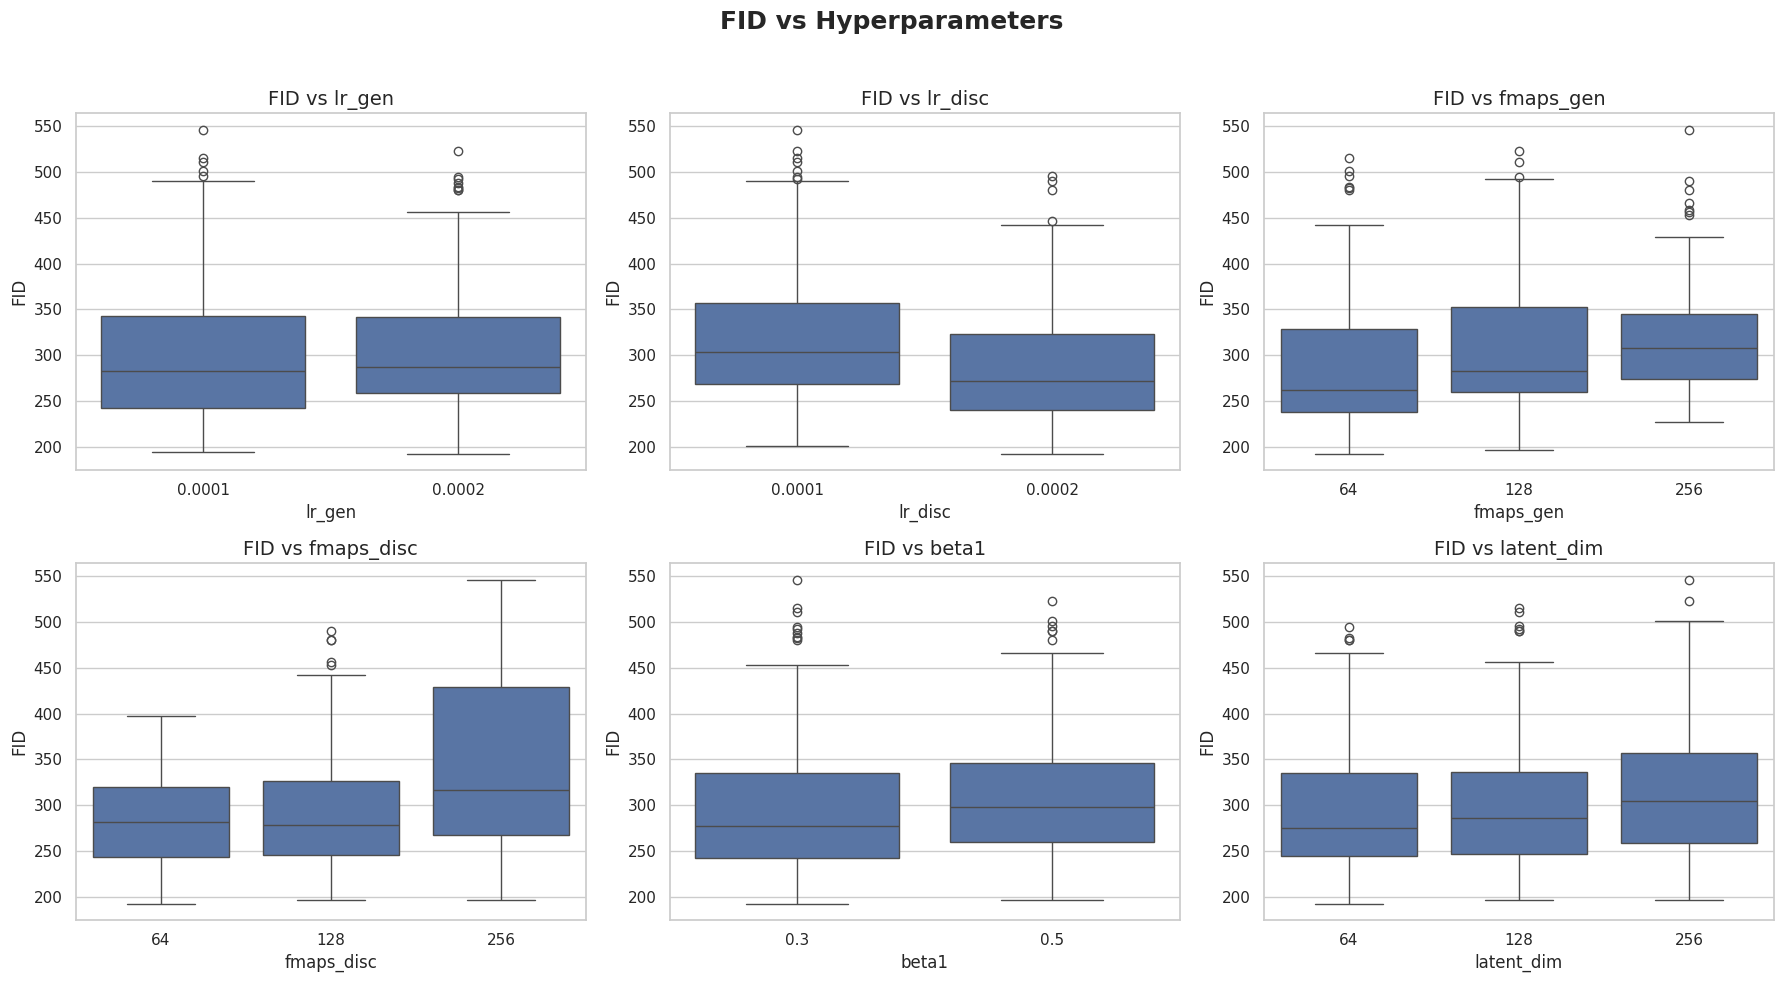

In [23]:
# plot FID vs each of the hyperparameters

hyperparams = ["lr_gen", "lr_disc", "fmaps_gen", "fmaps_disc", "beta1", "latent_dim"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, param in zip(axes.ravel(), hyperparams):
    if results_df[param].dtype not in [float, int]:
        results_df[param] = results_df[param].astype(str)

    sns.boxplot(x=param, y="fid", data=results_df, ax=ax)

    ax.set_title(f"FID vs {param}", fontsize=14)
    ax.set_xlabel(param, fontsize=12)
    ax.set_ylabel("FID", fontsize=12)

plt.suptitle("FID vs Hyperparameters", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

### Summary/Best Hyperparameters
I arrived at the following hyperparameters:
- **Loss Function:** BCE - I wasn't able to get coherent results when using MSE, maybe it was not suitable for my architecture.
- **Learning Rate (Generator):** 0.0002 - A moderate learning rate allowed the generator to learn sufficiently without overshooting optimal points. A higher value could lead to instability.
- **Learning Rate (Discriminator):** 0.0002 - The same learning rate for the discriminator ended up giving the best results.
- **Feature Maps (Generator):** 64 - A moderate fmap depth for the generator provided sufficient complexity without excess overhead.
- **Feature Maps (Discriminator):** 64 - I was concerned that the discriminator having the same learning rate/fmaps as the generator would lead to it overpowering, but this scenario did not end up playing out.
- **Beta1:** 0.3 - Beta1 values near 0.3 to 0.5 are commonly suggested for GANs because they help stabilize the Adam optimizer.
- **Latent Dimensions:** 64 - A lower latent dimension allowed the generator to still make images with enough detail while reducing the training costs.

### Troubleshooting
- My very first attempt using CycleGAN (not in this notebook) was unsuccessful as I found the architecture confusing and was not able to get it functioning.
- It took quite a bit of trial and error to get my DCGAN generator model to produce anything other than random noise. My original architecture attempted to generate 256x256 images but based on the training advice I found, I removed a couple convolution layers and reduced the output to 64x64. This new model trained faster and had improved results.
- My first attempts at hyperparameter tuning didn't go for nearly enough epochs and I was still seeing mostly noise after <50 epochs. After further experimentation I found that the models started to produce interesting results after 200-300 epochs and would converge and stop improving at around 500 epochs. Based on that I reduced my hyperparameter search space and increased the number of epochs to 500. It took several hours to get through all 144 iterations on my local 3080.
- Due to the complexity of the MiFID function used to evaluate submissions in Kaggle I decided to just use FID as my evaluation metric since it's built into existing libraries and I didn't need to implement it myself.
- I think that recent developments in generative AI gave me unrealistic expectations of what I could achieve using my own basic models. I first thought that I would be able to generate something that actually looks like a painting, but after many hours of experimentation I was happy to make something that could produce blobs with Monet-like color schemes.
- I realized late in this project that results continued to improve well beyond the 500 epoch range so I have no idea if the hyperparameters I chose are actually optimal for several thousand epochs.

In [ ]:
# re-train locally with the best hyperparameters and let it run a TON of epochs
# it takes ~20 minutes per 5,000 epochs on my computer

epochs = 25000
optimal_hyperparameters = {
    'lr_gen': 0.0002,
    'lr_disc': 0.0002,
    'fmaps_gen': 64,
    'fmaps_disc': 64,
    'beta1': 0.3,
    'latent_dim': 64,
    'loss_function': 'BCE',
}

gen = train_dcgan(optimal_hyperparameters, epochs, verbose=True, return_model=True)
gen.eval()

# the output of this cell has been scrubbed to reduce notebook size

In [38]:
# screenshots of all the outputs
html = ""
for i in range(1, 73):
    html += f'<img src="training-progress/{i}.png"><br>'

display(HTML(html))

In [31]:
# save a ton of fake images to a zip file to submit to Kaggle

import zipfile
from tqdm import tqdm

num_images = 10000
batch_size = 50

# save sample images directly to a zip file
with zipfile.ZipFile("images.zip", "w") as img_zip:
    num_batches = num_images // batch_size + int(num_images % batch_size != 0)
    img_counter = 0
    for _ in tqdm(range(num_batches), desc="Generating/Zipping Images"):
        current_batch_size = min(batch_size, num_images - img_counter)
        noise = torch.randn(current_batch_size, optimal_hyperparameters['latent_dim'], 1, 1, device=device)

        with torch.no_grad():
            fake_images = gen(noise)

        for i in range(current_batch_size):
            image_filename = f"{img_counter}.jpg"
            save_path = f"/tmp/{image_filename}"
            save_image((fake_images[i] + 1) / 2, save_path)
            img_zip.write(save_path, image_filename)
            os.remove(save_path)
            img_counter += 1

print("generated and zipped images for Kaggle")

Generating/Zipping Images: 100%|██████████| 200/200 [00:04<00:00, 43.07it/s]

generated and zipped images for Kaggle


## Conclusion

### Local Results
Just for fun I decided to run my final hyperparameters for 25,000 epochs locally because I wanted to see if the model would stop visibly improving at some point, or suffer from modal collapse or another type of regression. To my surprise, the model continued to produce better and better results even after thousands of epochs. The progress slowed down significantly but the results after 25k did not seem to be regressed from the results around ~10k. It's pretty subjective to decide if the 25k epoch images are "better" than the 10k ones but in my opinion they are. I think there's less repetitive noise and the images have more variety/plausibility, but the Kaggle results below disagree with me

Overall I was impressed with how the model kept improving over several thousand iterations. There are some outputs where the color and composition feels spot-on and I could momentarily think I'm looking at (a small thumbnail of) a Monet painting. Of course on further inspection it would be obvious that it's not actually a Monet painting, but the "feel" is certainly there.

### Kaggle Results
I re-created a minimal version of this notebook to run in Kaggle for 1000 epochs with my best hyperparameters and the notebook's final output scored **91.69** which put me in the lower half of the leaderboard. Seeing that I had up to 5 hours of GPU run time on Kaggle I turned the number of epochs up to 10,000 and ran it again and scored **79.59** which moved me to the middle of the leaderboard. After doing some napkin math I did another run with 30,000 epochs (which took 3.5 hours) and that scored **83.39** which doesn't seem different enough to be statistically significant but does indicate that the model's performance eventually plateaus.

### Takeaways
The early stages of this project were frustrating because it took me a long time to get anything that wasn't just random noise, and after that I was stuck in a rut of 100-500 epochs and thought "colorful blobs" was the best I could do. Only once I started cranking up the number of epochs did I see more coherent lines and patterns start to emerge in the images, and was happy to see some of the more repetitive themes go away as well so it didn't seem like the generator was suffering from modal collapse either. One thing didn't work for me was starting immediately at 256x256 with ~100 epochs and expecting to get coherent results, so once I scaled down to 64x64 and extended my training sequences I begant to see blobs of Monet-like colors and iterated from there. I also lost a lot of time testing on my local computer vs A100 in Google Colab and concluded that due to the small training batch sizes (because of the small dataset) I was being bottlenecked in non-GPU places and should just focus on maximizing the amount of training I can do on my local 3080 over a couple days.

### Future Improvements
- All of my results have a uniform pattern to them (often resembling a checkerboard) so I'd like to figure out how to avoid that in the future. At first I thought it was a form of modal collapse but now believe it's because my model is relatively shallow and that if I added 1-2 more deconvolution layers to scale up 128x128 or 256x256 across the pattern would vanish.
- Generating 128x128 or 256x256 sized images felt out of reach when I first started this project but now that I kinda know what I'm doing I think I could build a model to make bigger and better images.
- I would find a better way to tune hyperparameters because my best results didn't come until after 10,000 or more epochs. It's not practical to do a grid search in a reasonable amount of time over that many epochs.
- I should have been tracking FID when training my model for 25,000 epochs to see where the scores/performance peaks.